In [3]:
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms


In [30]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [6]:
import sys
sys.path.append('/content/drive/MyDrive/BikeProject/Tyre Component')

In [7]:
from helper_functions import set_seeds

In [8]:
# 1. Get pretrained weights for ViT-Base
pretrained_vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT

# 2. Setup a ViT model instance with pretrained weights
pretrained_vit = torchvision.models.vit_b_16(weights=pretrained_vit_weights).to(device)

# 3. Freeze the base parameters
for parameter in pretrained_vit.parameters():
    parameter.requires_grad = False

# 4. Change the classifier head
class_names = ['moderate','bad', 'Good']

set_seeds()
pretrained_vit.heads = nn.Linear(in_features=768, out_features=len(class_names)).to(device)
# pretrained_vit # uncomment for model output

In [10]:
!pip install torchinfo


In [11]:
from torchinfo import summary

# Print a summary using torchinfo (uncomment for actual output)
summary(model=pretrained_vit,
        input_size=(32, 3, 224, 224), # (batch_size, color_channels, height, width)
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [32, 3, 224, 224]    [32, 3]              768                  Partial
├─Conv2d (conv_proj)                                         [32, 3, 224, 224]    [32, 768, 14, 14]    (590,592)            False
├─Encoder (encoder)                                          [32, 197, 768]       [32, 197, 768]       151,296              False
│    └─Dropout (dropout)                                     [32, 197, 768]       [32, 197, 768]       --                   --
│    └─Sequential (layers)                                   [32, 197, 768]       [32, 197, 768]       --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [32, 197, 768]       [32, 197, 768]       (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [32, 197, 768]       [32, 

#### Notice how only the output layer is trainable, where as, all of the rest of the layers are untrainable (frozen).

In [12]:
# Setup directory paths to train and test images
train_dir = '/content/drive/MyDrive/BikeProject/Tyre Component/train'
test_dir = '/content/drive/MyDrive/BikeProject/Tyre Component/test'

Remember, if you're going to use a pretrained model, it's generally important to ensure your own custom data is transformed/formatted in the same way the data the original model was trained on.

In [13]:
# Get automatic transforms from pretrained ViT weights
pretrained_vit_transforms = pretrained_vit_weights.transforms()
print(pretrained_vit_transforms)

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)


## And now we've got transforms ready, we can turn our images into DataLoaders using the create_dataloaders()

In [14]:
import os

from torchvision import datasets, transforms
from torch.utils.data import DataLoader

NUM_WORKERS = os.cpu_count()

def create_dataloaders(
    train_dir: str,
    test_dir: str,
    transform: transforms.Compose,
    batch_size: int,
    num_workers: int=NUM_WORKERS
):

  # Use ImageFolder to create dataset(s)
  train_data = datasets.ImageFolder(train_dir, transform=transform)
  test_data = datasets.ImageFolder(test_dir, transform=transform)

  # Get class names
  class_names = train_data.classes

  # Turn images into data loaders
  train_dataloader = DataLoader(
      train_data,
      batch_size=batch_size,
      shuffle=True,
      num_workers=num_workers,
      pin_memory=True,
  )
  test_dataloader = DataLoader(
      test_data,
      batch_size=batch_size,
      shuffle=False,
      num_workers=num_workers,
      pin_memory=True,
  )

  return train_dataloader, test_dataloader, class_names

In [15]:
# Setup dataloaders
train_dataloader_pretrained, test_dataloader_pretrained, class_names = create_dataloaders(train_dir=train_dir,
                                                                                                     test_dir=test_dir,
                                                                                                     transform=pretrained_vit_transforms,
                                                                                                     batch_size=32) # Could increase if we had more samples, such as here: https://arxiv.org/abs/2205.01580 (there are other improvements there too...)


In [16]:
import sys
sys.path.append('/content/drive/MyDrive/BikeProject/Tyre Component')

In [17]:
from going_modular.going_modular import engine

# Create optimizer and loss function
optimizer = torch.optim.Adam(params=pretrained_vit.parameters(),
                             lr=1e-3)
loss_fn = torch.nn.CrossEntropyLoss()

# Train the classifier head of the pretrained ViT feature extractor model
set_seeds()
pretrained_vit_results = engine.train(model=pretrained_vit,
                                      train_dataloader=train_dataloader_pretrained,
                                      test_dataloader=test_dataloader_pretrained,
                                      optimizer=optimizer,
                                      loss_fn=loss_fn,
                                      epochs=10,
                                      device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9025 | train_acc: 0.5952 | test_loss: 1.6831 | test_acc: 0.2097
Epoch: 2 | train_loss: 0.6730 | train_acc: 0.7113 | test_loss: 2.1065 | test_acc: 0.2092
Epoch: 3 | train_loss: 0.6104 | train_acc: 0.7351 | test_loss: 2.2970 | test_acc: 0.2253
Epoch: 4 | train_loss: 0.5254 | train_acc: 0.8036 | test_loss: 2.3939 | test_acc: 0.2742
Epoch: 5 | train_loss: 0.5014 | train_acc: 0.8244 | test_loss: 2.5965 | test_acc: 0.2414
Epoch: 6 | train_loss: 0.4895 | train_acc: 0.8155 | test_loss: 2.6527 | test_acc: 0.2581
Epoch: 7 | train_loss: 0.4303 | train_acc: 0.8393 | test_loss: 2.7838 | test_acc: 0.2737
Epoch: 8 | train_loss: 0.4081 | train_acc: 0.8527 | test_loss: 2.8633 | test_acc: 0.2737
Epoch: 9 | train_loss: 0.4073 | train_acc: 0.8497 | test_loss: 2.9380 | test_acc: 0.2581
Epoch: 10 | train_loss: 0.3938 | train_acc: 0.8646 | test_loss: 3.0717 | test_acc: 0.1935


pretrained ViT performed far better than our custom ViT model trained from scratch (in the same amount of time).


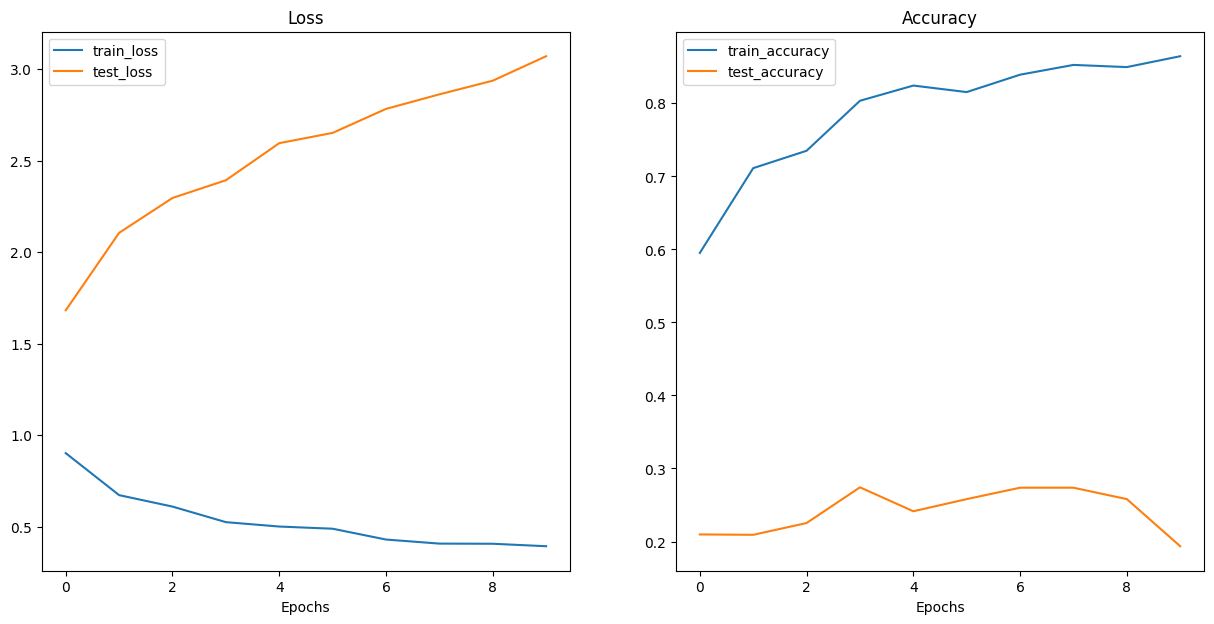

In [34]:
# Plot the loss curves
from helper_functions import plot_loss_curves

plot_loss_curves(pretrained_vit_results)

## That's the power of transfer learning!

We managed to get outstanding results with the same model architecture, except our custom implementation was trained from scratch (worse performance) and this feature extractor model has the power of pretrained weights from ImageNet behind it.

# Let's make Prediction:

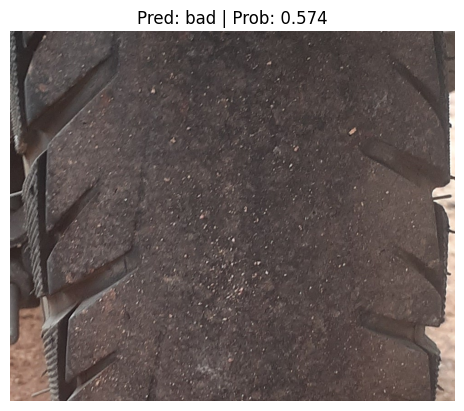

In [40]:
import requests

# Import function to make predictions on images and plot them
from going_modular.going_modular.predictions import pred_and_plot_image

# Setup custom image path
custom_image_path = "/content/drive/MyDrive/BikeProject/Tyre Component/valid/bad/10.jpg"

# Predict on custom image
pred_and_plot_image(model=pretrained_vit,
                    image_path=custom_image_path,
                    class_names=class_names)

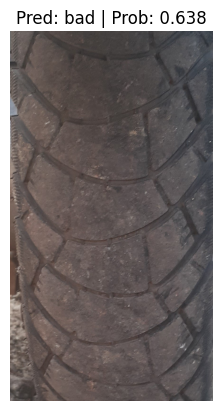

In [22]:
# Example usage
custom_image_path = '/content/drive/MyDrive/BikeProject/Tyre Component/valid/moderate/20230517_153737.jpg'


# Predict on custom image
pred_and_plot_image(model=pretrained_vit,
                    image_path=custom_image_path,
                    class_names=class_names)

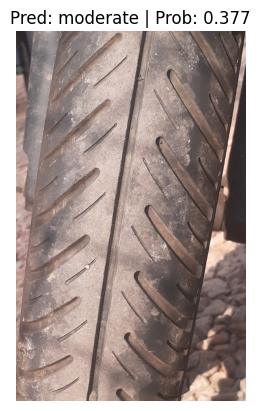

In [23]:

custom_image_path = '/content/drive/MyDrive/BikeProject/Tyre Component/valid/good/20230517_151919.jpg'
pred_and_plot_image(model=pretrained_vit,
                    image_path=custom_image_path,
                    class_names=class_names)

In [38]:
print('hi')

hi


In [39]:
custom_image_paths = [
    '/content/drive/MyDrive/BikeProject/Tyre Component/valid/good/20230517_152133.jpg',
    '/content/drive/MyDrive/BikeProject/Tyre Component/valid/good/20230517_153651.jpg',
    '/content/drive/MyDrive/BikeProject/Tyre Component/valid/good/20230517_153928.jpg',
    '/content/drive/MyDrive/BikeProject/Tyre Component/valid/good/20230517_152850.jpg',
    '/content/drive/MyDrive/BikeProject/Tyre Component/valid/good/20230517_152048.jpg',
    '/content/drive/MyDrive/BikeProject/Tyre Component/valid/good/20230517_151919.jpg',
    '/content/drive/MyDrive/BikeProject/Tyre Component/valid/good/20230517_152119.jpg',
    '/content/drive/MyDrive/BikeProject/Tyre Component/valid/good/41G9Yyoq9LL.jpg',
    '/content/drive/MyDrive/BikeProject/Tyre Component/valid/good/WhatsApp Image 2023-05-18 at 17.07.13.jpg',
    '/content/drive/MyDrive/BikeProject/Tyre Component/valid/good/WhatsApp Image 2023-05-18 at 21.47.21.jpg',
    '/content/drive/MyDrive/BikeProject/Tyre Component/valid/good/WhatsApp Image 2023-05-19 at 17.08.45.jpg',
    '/content/drive/MyDrive/BikeProject/Tyre Component/valid/good/WhatsApp Image 2023-05-19 at 17.08.46.jpg',
    '/content/drive/MyDrive/BikeProject/Tyre Component/valid/good/WhatsApp Image 2023-05-19 at 17.08.47.jpg',
    '/content/drive/MyDrive/BikeProject/Tyre Component/valid/good/WhatsApp Image 2023-05-19 at 17.08.48.jpg',
    '/content/drive/MyDrive/BikeProject/Tyre Component/valid/good/WhatsApp Image 2023-05-19 at 17.08.50.jpg',
    '/content/drive/MyDrive/BikeProject/Tyre Component/valid/good/WhatsApp Image 2023-05-19 at 17.08.51.jpg',
    '/content/drive/MyDrive/BikeProject/Tyre Component/valid/good/WhatsApp Image 2023-05-19 at 17.08.52.jpg',
    '/content/drive/MyDrive/BikeProject/Tyre Component/valid/good/WhatsApp Image 2023-05-19 at 17.08.54.jpg'
]

for image_path in custom_image_paths:
    pred_and_plot_image(model=pretrained_vit, image_path=image_path, class_names=class_names)
    plt.pause(3)  # Pause for 1 second

# Ensure all plots are shown at the end
plt.show()


Output hidden; open in https://colab.research.google.com to view.

In [ ]:
"""
Utility functions to make predictions.

Main reference for code creation: https://www.learnpytorch.io/06_pytorch_transfer_learning/#6-make-predictions-on-images-from-the-test-set
"""
import torch
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt

from typing import List, Tuple

from PIL import Image

# Set device
device = "cuda" if torch.cuda.is_available() else "cpu"

# Predict on a target image with a target model
# Function created in: https://www.learnpytorch.io/06_pytorch_transfer_learning/#6-make-predictions-on-images-from-the-test-set
def pred_and_plot_image(
    model: torch.nn.Module,
    class_names: List[str],
    image_path: str,
    image_size: Tuple[int, int] = (224, 224),
    transform: torchvision.transforms = None,
    device: torch.device = device,
):
    """Predicts on a target image with a target model.

    Args:
        model (torch.nn.Module): A trained (or untrained) PyTorch model to predict on an image.
        class_names (List[str]): A list of target classes to map predictions to.
        image_path (str): Filepath to target image to predict on.
        image_size (Tuple[int, int], optional): Size to transform target image to. Defaults to (224, 224).
        transform (torchvision.transforms, optional): Transform to perform on image. Defaults to None which uses ImageNet normalization.
        device (torch.device, optional): Target device to perform prediction on. Defaults to device.
    """

    # Open image
    img = Image.open(image_path)

    # Create transformation for image (if one doesn't exist)
    if transform is not None:
        image_transform = transform
    else:
        image_transform = transforms.Compose(
            [
                transforms.Resize(image_size),
                transforms.ToTensor(),
                transforms.Normalize(
                    mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
                ),
            ]
        )

    ### Predict on image ###

    # Make sure the model is on the target device
    model.to(device)

    # Turn on model evaluation mode and inference mode
    model.eval()
    with torch.inference_mode():
        # Transform and add an extra dimension to image (model requires samples in [batch_size, color_channels, height, width])
        transformed_image = image_transform(img).unsqueeze(dim=0)

        # Make a prediction on image with an extra dimension and send it to the target device
        target_image_pred = model(transformed_image.to(device))

    # Convert logits -> prediction probabilities (using torch.softmax() for multi-class classification)
    target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

    # Convert prediction probabilities -> prediction labels
    target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)
    print('hi')
    # Plot image with predicted label and probability
    plt.figure()
    plt.imshow(img)
    plt.title(
        f"Preed: {class_names[target_image_pred_label]} | Prob: {target_image_pred_probs.max():.3f}"
    )
    plt.axis(False)



In [52]:
# Predict on custom image 1
custom_image_path = '/content/drive/MyDrive/BikeProject/Tyre Component/valid/bad/3.jpg'
pred_and_plot_image(model=pretrained_vit,
                    image_path=custom_image_path,
                    class_names=class_names)

# Predict on custom image 2
custom_image_path = '/content/drive/MyDrive/BikeProject/Tyre Component/valid/bad/10.jpg'
pred_and_plot_image(model=pretrained_vit,
                    image_path=custom_image_path,
                    class_names=class_names)

# Predict on custom image 3
custom_image_path = '/content/drive/MyDrive/BikeProject/Tyre Component/valid/bad/11.jpg'
pred_and_plot_image(model=pretrained_vit,
                    image_path=custom_image_path,
                    class_names=class_names)

# Predict on custom image 4
custom_image_path = '/content/drive/MyDrive/BikeProject/Tyre Component/valid/bad/20230517_154520.jpg'
pred_and_plot_image(model=pretrained_vit,
                    image_path=custom_image_path,
                    class_names=class_names)

# Predict on custom image 5
custom_image_path = '/content/drive/MyDrive/BikeProject/Tyre Component/valid/bad/20230517_155141.jpg'
pred_and_plot_image(model=pretrained_vit,
                    image_path=custom_image_path,
                    class_names=class_names)

# Predict on custom image 6
custom_image_path = '/content/drive/MyDrive/BikeProject/Tyre Component/valid/bad/20230517_155607.jpg'
pred_and_plot_image(model=pretrained_vit,
                    image_path=custom_image_path,
                    class_names=class_names)

# Predict on custom image 7
custom_image_path = '/content/drive/MyDrive/BikeProject/Tyre Component/valid/bad/20230517_160615.jpg'
pred_and_plot_image(model=pretrained_vit,
                    image_path=custom_image_path,
                    class_names=class_names)

# Predict on custom image 8
custom_image_path = '/content/drive/MyDrive/BikeProject/Tyre Component/valid/bad/20230517_160234.jpg'
pred_and_plot_image(model=pretrained_vit,
                    image_path=custom_image_path,
                    class_names=class_names)

# Predict on custom image 9
custom_image_path = '/content/drive/MyDrive/BikeProject/Tyre Component/valid/bad/20230517_161105.jpg'
pred_and_plot_image(model=pretrained_vit,
                    image_path=custom_image_path,
                    class_names=class_names)

# Predict on custom image 10
custom_image_path = '/content/drive/MyDrive/BikeProject/Tyre Component/valid/bad/20230517_161037.jpg'
pred_and_plot_image(model=pretrained_vit,
                    image_path=custom_image_path,
                    class_names=class_names)

# Predict on custom image 11
custom_image_path = '/content/drive/MyDrive/BikeProject/Tyre Component/valid/bad/20230518_140143.jpg'
pred_and_plot_image(model=pretrained_vit,
                    image_path=custom_image_path,
                    class_names=class_names)

# Predict on custom image 12
custom_image_path = '/content/drive/MyDrive/BikeProject/Tyre Component/valid/bad/20230518_135810.jpg'
pred_and_plot_image(model=pretrained_vit,
                    image_path=custom_image_path,
                    class_names=class_names)

# Predict on custom image 13
custom_image_path = '/content/drive/MyDrive/BikeProject/Tyre Component/valid/bad/WhatsApp Image 2023-05-19 at 17.08.10.jpg'
pred_and_plot_image(model=pretrained_vit,
                    image_path=custom_image_path,
                    class_names=class_names)

# Predict on custom image 14
custom_image_path = '/content/drive/MyDrive/BikeProject/Tyre Component/valid/bad/WhatsApp Image 2023-05-19 at 17.08.12.jpg'
pred_and_plot_image(model=pretrained_vit,
                    image_path=custom_image_path,
                    class_names=class_names)

# Predict on custom image 15
custom_image_path = '/content/drive/MyDrive/BikeProject/Tyre Component/valid/bad/WhatsApp Image 2023-05-20 at 17.56.38.jpg'
pred_and_plot_image(model=pretrained_vit,
                    image_path=custom_image_path,
                    class_names=class_names)

# Predict on custom image 16
custom_image_path = '/content/drive/MyDrive/BikeProject/Tyre Component/valid/bad/WhatsApp Image 2023-05-18 at 22.07.47.jpg'
pred_and_plot_image(model=pretrained_vit,
                    image_path=custom_image_path,
                    class_names=class_names)

# Predict on custom image 17
custom_image_path = '/content/drive/MyDrive/BikeProject/Tyre Component/valid/bad/WhatsApp Image 2023-05-20 at 17.56.43.jpg'
pred_and_plot_image(model=pretrained_vit,
                    image_path=custom_image_path,
                    class_names=class_names)

# Predict on custom image 18
custom_image_path = '/content/drive/MyDrive/BikeProject/Tyre Component/valid/bad/WhatsApp Image 2023-05-18 at 22.07.48.jpg'
pred_and_plot_image(model=pretrained_vit,
                    image_path=custom_image_path,
                    class_names=class_names)

# Predict on custom image 19
custom_image_path = '/content/drive/MyDrive/BikeProject/Tyre Component/valid/bad/WhatsApp Image 2023-05-18 at 22.07.46.jpg'
pred_and_plot_image(model=pretrained_vit,
                    image_path=custom_image_path,
                    class_names=class_names)

# Predict on custom image 20
custom_image_path = '/content/drive/MyDrive/BikeProject/Tyre Component/valid/bad/WhatsApp Image 2023-05-20 at 17.56.44.jpg'
pred_and_plot_image(model=pretrained_vit,
                    image_path=custom_image_path,
                    class_names=class_names)

# Predict on custom image 21
custom_image_path = '/content/drive/MyDrive/BikeProject/Tyre Component/valid/bad/WhatsApp Image 2023-05-19 at 17.08.14.jpg'
pred_and_plot_image(model=pretrained_vit,
                    image_path=custom_image_path,
                    class_names=class_names)

# Predict on custom image 22
custom_image_path = '/content/drive/MyDrive/BikeProject/Tyre Component/valid/bad/X0wJDEkbx40lUqLakhvWY7L_QcwQBJ0cArPAheT7R98.jpg'
pred_and_plot_image(model=pretrained_vit,
                    image_path=custom_image_path,
                    class_names=class_names)

